In [1]:
#import Pkg; Pkg.add("PyCall")
#import Pkg; Pkg.add("PyPlot")
using PyCall
using PyPlot
np = pyimport("numpy")
io = pyimport("skimage.io")
pylab = pyimport("pylab")
pylab.rcParams["figure.figsize"] = (8.0, 10.0)
py"""
import sys
sys.path.insert(0, "./")
"""
pycocotools_coco = pyimport("pycocotools.coco");

In [2]:
using Plots
using Base.Iterators: flatten
using IterTools: ncycle, takenth
using Statistics: mean
import CUDA # functional
import Knet # load, save
using Knet#: conv4, pool, mat, KnetArray, nll, zeroone, progress, sgd, param, param0, dropout, relu, minibatch, Data, sigm
using BenchmarkTools
using StatsBase


# Load Images from dataset

In [3]:
dataDir="/datasets/COCO"
dataType="train2017"
annFile="$dataDir/annotations/instances_$dataType.json"
coco = pycocotools_coco.COCO(annFile);

In [4]:
catIds = coco.getCatIds(catNms=["person","dog","skateboard"]);
imgIds = coco.getImgIds(catIds=catIds);

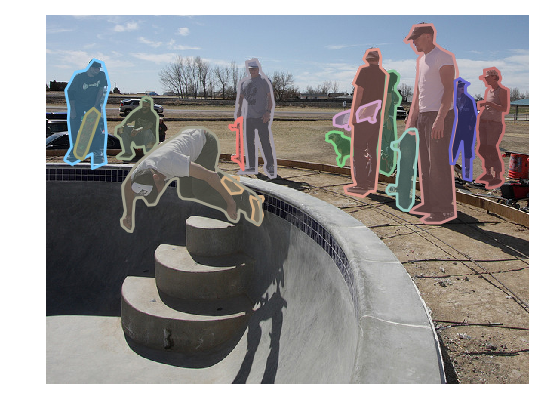

102599

In [5]:
id = imgIds[np.random.randint(1,length(imgIds))]
#id = 306440
print(id)
# load and display image
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
img = coco.loadImgs(id)[1]
annIds = coco.getAnnIds(imgIds=id, catIds=catIds, iscrowd=nothing)
#print(annIds);print("\n");
anns = coco.loadAnns(annIds)
#print(anns);print("\n");
I = io.imread(img["coco_url"])
plt.switch_backend("agg")
plt.axis("off")
plt.imshow(I)
plt.show()
r = coco.showAnns(anns);

In [6]:
img

Dict{Any,Any} with 8 entries:
  "file_name"     => "000000102599.jpg"
  "height"        => 490
  "id"            => 102599
  "width"         => 640
  "license"       => 3
  "date_captured" => "2013-11-20 09:04:47"
  "flickr_url"    => "http://farm4.staticflickr.com/3548/3357923122_ce774230e3_…
  "coco_url"      => "http://images.cocodataset.org/train2017/000000102599.jpg"

In [7]:
I = permutedims(I,(2,1,3));

In [8]:
imgData = reshape(KnetArray(Float32.(I/255)),(size(I)...,1));

# Feature Pyramid Network
https://medium.com/@hirotoschwert/digging-into-detectron-2-part-2-dd6e8b0526e
![Feature Pyramid Network](img/base-rcnn-fpn.png)

## Backbone Network
![Feature Pyramid Network](img/backbone-network.png)

In [9]:
struct Conv; w; b; f; p; end
(c::Conv)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p)) .+ c.b))
Conv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) =
Conv(param(w1,w2,cx,cy;init=gaussian), param0(1,1,cy,1), f, pdrop)

Conv

In [10]:
@doc param

```
param(array; atype)
param(dims...; init, atype)
param0(dims...; atype)
```

The first form returns `Param(atype(array))`.

The second form Returns a randomly initialized `Param(atype(init(dims...)))`.  

The third form `param0` is an alias for `param(dims...; init=zeros)`.

By default, `init` is `xavier_uniform` and `atype` is `Knet.atype()`.


In [11]:
# Define a convolutional layer:
struct BasicStem; w; b; f; p; end
(bs::BasicStem)(x) =
    bs.f.(pool(conv4(bs.w, dropout(x,bs.p),stride=2,padding=3)
        .+ bs.b,window=2))
BasicStem(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) =
BasicStem(param(w1,w2,cx,cy;init=gaussian), param0(1,1,cy,1), f, pdrop)


BasicStem

### Bottleneck Blocks
![Feature Pyramid Network](img/bottleneck-blocks.png)

In [12]:
# Define a convolutional layer:
struct BottleneckBlock_a; w1; w2; w3; p; end
(this::BottleneckBlock_a)(x) = relu.(
    conv4(this.w3, dropout(
            relu.(conv4(this.w2, dropout(
                    relu.(conv4(this.w1, dropout(x,this.p)))
                    ,this.p),
                    padding=1))
            ,this.p)) .+
    x
)
BottleneckBlock_a(cx::Int,cy::Int;pdrop=0) =
    BottleneckBlock_a(
        param(1,1,cx,cy), #w1
        param(3,3,cy,cy), #w2
        param(1,1,cy,cx), #w3
        pdrop
    )
# Define a convolutional layer:
struct BottleneckBlock_b; w0; w1; w2; w3; p; end
(this::BottleneckBlock_b)(x) = relu.(
    conv4(this.w3, dropout(
            relu.(conv4(this.w2, dropout(
                    relu.(conv4(this.w1, dropout(x,this.p)))
                    ,this.p),
                    padding=1)
                )
            ,this.p)) .+
    conv4(this.w0, dropout(x,this.p))
)
BottleneckBlock_b(cx::Int,cy::Int;pdrop=0) =
    BottleneckBlock_b(
        param(1,1,cx,cy), #w0
        param(1,1,cx,cx), #w1
        param(3,3,cx,cx), #w2
        param(1,1,cx,cy), #w3
        pdrop
    )
# Define a convolutional layer:
struct BottleneckBlock_c; w0; w1; w2; w3; p; end
(this::BottleneckBlock_c)(x) = relu.(
    conv4(this.w3, dropout(
            relu.(conv4(this.w2, dropout(
                    relu.(conv4(this.w1, dropout(x,this.p),stride=2))
                    ,this.p),
                    padding=1)
                )
            ,this.p)) .+
    conv4(this.w0, dropout(x,this.p),stride=2)
)
BottleneckBlock_c(cx::Int,cy::Int,ci::Int;pdrop=0) =
    BottleneckBlock_c(
        param(1,1,cx,cy), #w0
        param(1,1,cx,ci), #w1
        param(3,3,ci,ci), #w2
        param(1,1,ci,cy), #w3
        pdrop
    )


BottleneckBlock_c

In [13]:
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = sse(c(x),y)

In [14]:
conv_chain = Chain(
    BasicStem(7,7,3,64),
    BottleneckBlock_b(64,256),
    BottleneckBlock_a(256,64),
    BottleneckBlock_c(256,512,128),
    BottleneckBlock_a(512,128),
    BottleneckBlock_a(512,128),
    BottleneckBlock_a(512,128),
    BottleneckBlock_c(512,1024,256),
    BottleneckBlock_a(1024,256),
    BottleneckBlock_a(1024,256),
    BottleneckBlock_a(1024,256),
    BottleneckBlock_a(1024,256),
    BottleneckBlock_c(1024,2048,512),
    BottleneckBlock_a(2048,4096),
    BottleneckBlock_a(2048,4096),
)

Chain((BasicStem(P(KnetArray{Float32,4}(7,7,3,64)), P(KnetArray{Float32,4}(1,1,64,1)), Knet.Ops20.relu, 0), BottleneckBlock_b(P(KnetArray{Float32,4}(1,1,64,256)), P(KnetArray{Float32,4}(1,1,64,64)), P(KnetArray{Float32,4}(3,3,64,64)), P(KnetArray{Float32,4}(1,1,64,256)), 0), BottleneckBlock_a(P(KnetArray{Float32,4}(1,1,256,64)), P(KnetArray{Float32,4}(3,3,64,64)), P(KnetArray{Float32,4}(1,1,64,256)), 0), BottleneckBlock_c(P(KnetArray{Float32,4}(1,1,256,512)), P(KnetArray{Float32,4}(1,1,256,128)), P(KnetArray{Float32,4}(3,3,128,128)), P(KnetArray{Float32,4}(1,1,128,512)), 0), BottleneckBlock_a(P(KnetArray{Float32,4}(1,1,512,128)), P(KnetArray{Float32,4}(3,3,128,128)), P(KnetArray{Float32,4}(1,1,128,512)), 0), BottleneckBlock_a(P(KnetArray{Float32,4}(1,1,512,128)), P(KnetArray{Float32,4}(3,3,128,128)), P(KnetArray{Float32,4}(1,1,128,512)), 0), BottleneckBlock_a(P(KnetArray{Float32,4}(1,1,512,128)), P(KnetArray{Float32,4}(3,3,128,128)), P(KnetArray{Float32,4}(1,1,128,512)), 0), Bottleneck

In [15]:
#@benchmark conv_chain(imgData)

In [16]:
struct Pyramid
    stem
    layers
    Pyramid(stem, layers...) = new(stem,layers)
end
function (p::Pyramid)(x)
    # Climbing up the pyramid
    r = p.stem(x);
    featureMaps = ();
    for l in p.layers;
        r = l(r);
        featureMaps = (featureMaps...,r);
    end
    featureMaps;
end

In [17]:
backbone = Pyramid(
    BasicStem(7,7,3,64),
    Chain(
        BottleneckBlock_b(64,256),
        BottleneckBlock_a(256,64)
        ),
    Chain(
        BottleneckBlock_c(256,512,128),
        BottleneckBlock_a(512,128),
        BottleneckBlock_a(512,128),
        BottleneckBlock_a(512,128),
        ),
    Chain(
        BottleneckBlock_c(512,1024,256),
        BottleneckBlock_a(1024,256),
        BottleneckBlock_a(1024,256),
        BottleneckBlock_a(1024,256),
        BottleneckBlock_a(1024,256),
        ),
    Chain(
        BottleneckBlock_c(1024,2048,512),
        BottleneckBlock_a(2048,4096),
        BottleneckBlock_a(2048,4096),
        ),
    Chain(
        x -> pool(x)
        )
)

Pyramid(BasicStem(P(KnetArray{Float32,4}(7,7,3,64)), P(KnetArray{Float32,4}(1,1,64,1)), Knet.Ops20.relu, 0), (Chain((BottleneckBlock_b(P(KnetArray{Float32,4}(1,1,64,256)), P(KnetArray{Float32,4}(1,1,64,64)), P(KnetArray{Float32,4}(3,3,64,64)), P(KnetArray{Float32,4}(1,1,64,256)), 0), BottleneckBlock_a(P(KnetArray{Float32,4}(1,1,256,64)), P(KnetArray{Float32,4}(3,3,64,64)), P(KnetArray{Float32,4}(1,1,64,256)), 0))), Chain((BottleneckBlock_c(P(KnetArray{Float32,4}(1,1,256,512)), P(KnetArray{Float32,4}(1,1,256,128)), P(KnetArray{Float32,4}(3,3,128,128)), P(KnetArray{Float32,4}(1,1,128,512)), 0), BottleneckBlock_a(P(KnetArray{Float32,4}(1,1,512,128)), P(KnetArray{Float32,4}(3,3,128,128)), P(KnetArray{Float32,4}(1,1,128,512)), 0), BottleneckBlock_a(P(KnetArray{Float32,4}(1,1,512,128)), P(KnetArray{Float32,4}(3,3,128,128)), P(KnetArray{Float32,4}(1,1,128,512)), 0), BottleneckBlock_a(P(KnetArray{Float32,4}(1,1,512,128)), P(KnetArray{Float32,4}(3,3,128,128)), P(KnetArray{Float32,4}(1,1,128,512

In [18]:
#@benchmark pyramid_o = backbone(imgData)

In [19]:
struct onlyConv; w; f; p; pad; end
(c::onlyConv)(x) = c.f.(conv4(c.w, dropout(x,c.p),padding=c.pad))
onlyConv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0,padding=0) =
onlyConv(param(w1,w2,cx,cy), f, pdrop,padding)

onlyConv

In [20]:
struct FPN
    pyramid
    lateral_layers
    output_layers
    FPN(pyramid,lateral_layers,output_layers) =
        new(pyramid,lateral_layers,output_layers)
end
function (fpn::FPN)(x)
    # Climbing up the pyramid
    y = fpn.pyramid(x);
    L = ();
    # Reduce #channels
    for i in 1:length(fpn.lateral_layers)
        L = (L...,fpn.lateral_layers[i](y[i]))
    end
    # TODO: upsample and add
    
    # output
    O = ();
    for i in 1:length(fpn.output_layers)
        O = (O...,fpn.output_layers[i](L[i]))
    end
    (O...,L[end])
end



In [21]:
myFPN = FPN(
    backbone,
    [
        onlyConv(1,1,256,256),
        onlyConv(1,1,512,256),
        onlyConv(1,1,1024,256),
        onlyConv(1,1,2048,256),
        onlyConv(1,1,2048,256)
    ],
    [
        onlyConv(3,3,256,256,padding=1),
        onlyConv(3,3,256,256,padding=1),
        onlyConv(3,3,256,256,padding=1),
        onlyConv(3,3,256,256,padding=1)
    ]
);

In [22]:
#@benchmark myFPN(imgData)

In [23]:
struct RPN_head
    conv_plain
    objectness_logit_conv
    anchor_deltas_conv
    RPN_head(conv_plain,objectness_logit_conv,anchor_deltas_conv) =
        new(conv_plain,objectness_logit_conv,anchor_deltas_conv)
end
function (rpnh::RPN_head)(x)
    objectness_logit = [];
    anchor_deltas = [];
    # for each head in bundle (P2 to P6)
    for h in x
        temp = rpnh.conv_plain(h)
        push!(objectness_logit, rpnh.objectness_logit_conv(temp))
        push!(anchor_deltas, rpnh.anchor_deltas_conv(temp))
    end
    (objectness_logit,anchor_deltas)
end

In [24]:
myRPN_head = RPN_head(
    onlyConv(3,3,256,256,padding=1),
    onlyConv(1,1,256,3,sigm),
    onlyConv(1,1,256,3*4)
)

RPN_head(onlyConv(P(KnetArray{Float32,4}(3,3,256,256)), Knet.Ops20.relu, 0, 1), onlyConv(P(KnetArray{Float32,4}(1,1,256,3)), Knet.Ops20.sigm, 0, 0), onlyConv(P(KnetArray{Float32,4}(1,1,256,12)), Knet.Ops20.relu, 0, 0))

In [25]:
img_objectness_logits, img_anchor_deltas =
    myRPN_head(myFPN(imgData))

(Any[K32(160,122,3,1)[0.49836606⋯], K32(80,61,3,1)[0.4991354⋯], K32(40,31,3,1)[0.49989676⋯], K32(20,16,3,1)[0.4989362⋯], K32(10,8,3,1)[0.49885303⋯]], Any[K32(160,122,12,1)[0.0⋯], K32(80,61,12,1)[0.0⋯], K32(40,31,12,1)[0.0⋯], K32(20,16,12,1)[0.0⋯], K32(10,8,12,1)[0.0⋯]])

### Feature Map Visualization
![Feature Pyramid Network](img/receptive-field.png)

In [26]:
img_objectness_logits

5-element Array{Any,1}:
 K32(160,122,3,1)[0.49836606⋯]
 K32(80,61,3,1)[0.4991354⋯]
 K32(40,31,3,1)[0.49989676⋯]
 K32(20,16,3,1)[0.4989362⋯]
 K32(10,8,3,1)[0.49885303⋯]

In [27]:
img_anchor_deltas

5-element Array{Any,1}:
 K32(160,122,12,1)[0.0⋯]
 K32(80,61,12,1)[0.0⋯]
 K32(40,31,12,1)[0.0⋯]
 K32(20,16,12,1)[0.0⋯]
 K32(10,8,12,1)[0.0⋯]

In [28]:
#https://github.com/facebookresearch/detectron2/blob/5e2a1ecccd228227c5a605c0a98d58e1b2db3640/detectron2/modeling/anchor_generator.py#L140-L177
function generate_cell_anchors(
        sizes=(32,64,128,256,512),
        aspect_ratios=(0.5,1,2)
    )
    anchors = []
    for size in sizes
        anchor = []
        area = size ^ 2.0
        for aspect_ratio in aspect_ratios
            # s * s = w * h
            # a = h / w
            # ... some algebra ...
            # w = sqrt(s * s / a)
            # h = a * w
            w = sqrt(area / aspect_ratio)
            h = aspect_ratio * w
            x0, y0, x1, y1 = -w / 2.0, -h / 2.0, w / 2.0, h / 2.0
            append!(anchor,[[x0, y0, x1, y1]])
        end
        append!(anchors,[anchor])
    end
    anchors
end


generate_cell_anchors (generic function with 3 methods)

In [29]:
cell_anchors = generate_cell_anchors()

5-element Array{Any,1}:
 Any[[-22.627416997969522, -11.313708498984761, 22.627416997969522, 11.313708498984761], [-16.0, -16.0, 16.0, 16.0], [-11.313708498984761, -22.627416997969522, 11.313708498984761, 22.627416997969522]]
 Any[[-45.254833995939045, -22.627416997969522, 45.254833995939045, 22.627416997969522], [-32.0, -32.0, 32.0, 32.0], [-22.627416997969522, -45.254833995939045, 22.627416997969522, 45.254833995939045]]
 Any[[-90.50966799187809, -45.254833995939045, 90.50966799187809, 45.254833995939045], [-64.0, -64.0, 64.0, 64.0], [-45.254833995939045, -90.50966799187809, 45.254833995939045, 90.50966799187809]]
 Any[[-181.01933598375618, -90.50966799187809, 181.01933598375618, 90.50966799187809], [-128.0, -128.0, 128.0, 128.0], [-90.50966799187809, -181.01933598375618, 90.50966799187809, 181.01933598375618]]
 Any[[-362.03867196751236, -181.01933598375618, 362.03867196751236, 181.01933598375618], [-256.0, -256.0, 256.0, 256.0], [-181.01933598375618, -362.03867196751236, 181.01933598

In [30]:
# inputs:
# boxA = [top left x, top left y, width, height]
# boxB = [top left x, top left y, width, height]
function bb_intersection_over_union(boxA, boxB)
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[1], boxB[1])
    yA = max(boxA[2], boxB[2])
    xB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    yB = min(boxA[2] + boxA[4], boxB[2] + boxB[4])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = boxA[3] * boxA[4]
    boxBArea = boxB[3] * boxB[4]
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / (boxAArea + boxBArea - interArea)
    # return the intersection over union value
end

bb_intersection_over_union (generic function with 1 method)

In [31]:
bb_intersection_over_union([1,0,2,2], [1,1,1,1])

0.25

In [32]:
strides = KnetArray([4,8,16,32,64])

5-element KnetArray{Int64,1}:
  4
  8
 16
 32
 64

In [33]:
anchors = []
for anchor in 1:length(img_anchor_deltas)
    a = []
    for i = 1:size(img_anchor_deltas[anchor],1)
        for j = 1:size(img_anchor_deltas[anchor],2)
            b = []
            for c in cell_anchors[anchor]
                append!(b,[[strides[anchor]*i,strides[anchor]*j,0,0]+c])
            end
            append!(a,b) 
        end
    end
    append!(anchors,a) 
end
summary(anchors)


"78120-element Array{Any,1}"

In [34]:
anchors

78120-element Array{Any,1}:
 [-18.627416997969522, -7.313708498984761, 22.627416997969522, 11.313708498984761]
 [-12.0, -12.0, 16.0, 16.0]
 [-7.313708498984761, -18.627416997969522, 11.313708498984761, 22.627416997969522]
 [-18.627416997969522, -3.313708498984761, 22.627416997969522, 11.313708498984761]
 [-12.0, -8.0, 16.0, 16.0]
 [-7.313708498984761, -14.627416997969522, 11.313708498984761, 22.627416997969522]
 [-18.627416997969522, 0.6862915010152388, 22.627416997969522, 11.313708498984761]
 [-12.0, -4.0, 16.0, 16.0]
 [-7.313708498984761, -10.627416997969522, 11.313708498984761, 22.627416997969522]
 [-18.627416997969522, 4.686291501015239, 22.627416997969522, 11.313708498984761]
 [-12.0, 0.0, 16.0, 16.0]
 [-7.313708498984761, -6.627416997969522, 11.313708498984761, 22.627416997969522]
 [-18.627416997969522, 8.686291501015239, 22.627416997969522, 11.313708498984761]
 ⋮
 [277.96132803248764, 138.98066401624382, 362.03867196751236, 181.01933598375618]
 [384.0, 64.0, 256.0, 256.0]
 [458.

In [35]:
size(img_anchor_deltas[1])

(160, 122, 12, 1)

In [36]:
gt_bboxs = [];
for ann in anns
    append!(gt_bboxs,[ann["bbox"]])
end
gt_bboxs

15-element Array{Any,1}:
 [232.28, 214.41, 55.7, 63.99]
 [24.28, 59.04, 59.59, 144.57]
 [91.34, 108.61, 56.68, 82.48]
 [250.15, 59.06, 54.01, 156.5]
 [474.78, 12.58, 70.7, 263.27]
 [534.88, 83.75, 37.16, 135.74]
 [99.1, 148.79, 185.3, 138.51]
 [439.39, 73.97, 30.45, 138.63]
 [381.02, 113.99, 61.77, 38.32]
 [451.1, 150.96, 41.65, 108.4]
 [242.98, 135.93, 17.86, 69.17]
 [36.88, 123.41, 34.04, 68.6]
 [370.89, 154.59, 34.44, 46.0]
 [394.96, 45.3, 58.27, 195.53]
 [570.04, 70.18, 42.97, 159.07]

In [37]:
print( gt_bboxs[1]);print("\n");
bb_intersection_over_union(gt_bboxs[1], gt_bboxs[1])

[232.28, 214.41, 55.7, 63.99]


0.9999999999999998

In [38]:
IoU_matrix = zeros(Float32,length(gt_bboxs),length(anchors))

15×78120 Array{Float32,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0

In [39]:
for i = 1:length(gt_bboxs)
    for j = 1:length(anchors)
        IoU_matrix[i,j] =
            bb_intersection_over_union(gt_bboxs[i], anchors[j])
    end
end
IoU_matrix

15×78120 Array{Float32,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0169603   0.118279
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0         0.0379974
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0         0.00984718
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.00200175  0.0551375
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [40]:
function get_IoUs(gt,anc)
    IoU_matrix = zeros(Float32,length(gt),length(anc))
    for i = 1:length(gt)
        for j = 1:length(anc)
            IoU_matrix[i,j] =
                bb_intersection_over_union(gt[i], anc[j])
        end
    end
    IoU_matrix
end

get_IoUs (generic function with 1 method)

In [41]:
IoU_matrix = get_IoUs(gt_bboxs,anchors)

15×78120 Array{Float32,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0169603   0.118279
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0         0.0379974
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0         0.00984718
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.00200175  0.0551375
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [42]:
IoU_foreground_th = 0.25;
IoU_background_th = 0.25;
function matcher(x)
    if (x >= IoU_foreground_th)
        return 1;
    elseif (x <= IoU_background_th)
        return 0;
    else
        return -1;
    end
end
@time IoU_labels = matcher.(IoU_matrix)

  0.165303 seconds (2.57 M allocations: 56.566 MiB, 9.77% gc time)


15×78120 Array{Int64,2}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  1  0  0  1  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0 

In [43]:
for i in 1:size(IoU_matrix,1)
    print(IoU_matrix[i,argmax(IoU_matrix[i,:])]);print("\n")
end

0.7204441
0.5258134
0.7408418
0.51590365
0.55771315
0.58221906
0.63265705
0.49557427
0.56012017
0.7786872
0.55698264
0.5701035
0.6463667
0.5996567
0.4583752


In [44]:
@time anchor_candidates = findall(x->x==1,IoU_labels)

  0.062247 seconds (155.81 k allocations: 8.060 MiB)


911-element Array{CartesianIndex{2},1}:
 CartesianIndex(12, 59718)
 CartesianIndex(12, 59721)
 CartesianIndex(12, 59724)
 CartesianIndex(12, 59727)
 CartesianIndex(12, 59730)
 CartesianIndex(12, 59733)
 CartesianIndex(12, 59897)
 CartesianIndex(12, 59900)
 CartesianIndex(12, 59901)
 CartesianIndex(12, 59903)
 CartesianIndex(12, 59904)
 CartesianIndex(12, 59906)
 CartesianIndex(12, 59907)
 ⋮
 CartesianIndex(7, 78017)
 CartesianIndex(7, 78034)
 CartesianIndex(7, 78037)
 CartesianIndex(7, 78061)
 CartesianIndex(5, 78083)
 CartesianIndex(5, 78084)
 CartesianIndex(5, 78087)
 CartesianIndex(5, 78090)
 CartesianIndex(5, 78107)
 CartesianIndex(5, 78108)
 CartesianIndex(5, 78111)
 CartesianIndex(5, 78114)

In [45]:
@time anchor_background = findall(x->x==0,IoU_labels)

  0.097594 seconds (107.14 k allocations: 38.366 MiB, 19.02% gc time)


1170889-element Array{CartesianIndex{2},1}:
 CartesianIndex(1, 1)
 CartesianIndex(2, 1)
 CartesianIndex(3, 1)
 CartesianIndex(4, 1)
 CartesianIndex(5, 1)
 CartesianIndex(6, 1)
 CartesianIndex(7, 1)
 CartesianIndex(8, 1)
 CartesianIndex(9, 1)
 CartesianIndex(10, 1)
 CartesianIndex(11, 1)
 CartesianIndex(12, 1)
 CartesianIndex(13, 1)
 ⋮
 CartesianIndex(4, 78120)
 CartesianIndex(5, 78120)
 CartesianIndex(6, 78120)
 CartesianIndex(7, 78120)
 CartesianIndex(8, 78120)
 CartesianIndex(9, 78120)
 CartesianIndex(10, 78120)
 CartesianIndex(11, 78120)
 CartesianIndex(12, 78120)
 CartesianIndex(13, 78120)
 CartesianIndex(14, 78120)
 CartesianIndex(15, 78120)

In [46]:
@time findall(x->x==-1,IoU_labels)

  0.054979 seconds (107.12 k allocations: 5.368 MiB)


CartesianIndex{2}[]

In [47]:
RPN_BATCH_SIZE_PER_IMAGE = 256;
RPN_POSITIVE_FRACTION = 0.5;

In [48]:
#import Pkg; Pkg.add("StatsBase")

In [49]:
downsampled_candidates =
    length(anchor_candidates) > RPN_BATCH_SIZE_PER_IMAGE * RPN_POSITIVE_FRACTION ?
    sample(anchor_candidates,Int64(RPN_BATCH_SIZE_PER_IMAGE * RPN_POSITIVE_FRACTION),replace=false) :
    anchor_candidates


128-element Array{CartesianIndex{2},1}:
 CartesianIndex(7, 78037)
 CartesianIndex(4, 77418)
 CartesianIndex(12, 60266)
 CartesianIndex(6, 77756)
 CartesianIndex(15, 76665)
 CartesianIndex(9, 68678)
 CartesianIndex(2, 73503)
 CartesianIndex(13, 67964)
 CartesianIndex(14, 75833)
 CartesianIndex(1, 64691)
 CartesianIndex(3, 73974)
 CartesianIndex(15, 76670)
 CartesianIndex(1, 74745)
 ⋮
 CartesianIndex(13, 75573)
 CartesianIndex(4, 77367)
 CartesianIndex(8, 75926)
 CartesianIndex(5, 77804)
 CartesianIndex(7, 78034)
 CartesianIndex(7, 77997)
 CartesianIndex(10, 76125)
 CartesianIndex(1, 65056)
 CartesianIndex(14, 77657)
 CartesianIndex(7, 77279)
 CartesianIndex(2, 73512)
 CartesianIndex(1, 74930)

In [50]:
downsampled_background =
    sample(anchor_candidates,Int64(RPN_BATCH_SIZE_PER_IMAGE-length(downsampled_candidates)),replace=false)

128-element Array{CartesianIndex{2},1}:
 CartesianIndex(3, 73881)
 CartesianIndex(5, 78087)
 CartesianIndex(9, 68680)
 CartesianIndex(14, 75657)
 CartesianIndex(2, 77088)
 CartesianIndex(6, 76398)
 CartesianIndex(4, 75006)
 CartesianIndex(11, 64481)
 CartesianIndex(7, 77425)
 CartesianIndex(12, 59916)
 CartesianIndex(4, 74987)
 CartesianIndex(4, 74808)
 CartesianIndex(9, 67942)
 ⋮
 CartesianIndex(10, 76127)
 CartesianIndex(3, 73886)
 CartesianIndex(9, 75558)
 CartesianIndex(4, 77424)
 CartesianIndex(4, 77468)
 CartesianIndex(2, 73512)
 CartesianIndex(13, 75748)
 CartesianIndex(4, 74909)
 CartesianIndex(2, 77081)
 CartesianIndex(2, 73503)
 CartesianIndex(5, 77754)
 CartesianIndex(13, 67786)

In [51]:
downsampled = vcat(downsampled_candidates,downsampled_background)

256-element Array{CartesianIndex{2},1}:
 CartesianIndex(7, 78037)
 CartesianIndex(4, 77418)
 CartesianIndex(12, 60266)
 CartesianIndex(6, 77756)
 CartesianIndex(15, 76665)
 CartesianIndex(9, 68678)
 CartesianIndex(2, 73503)
 CartesianIndex(13, 67964)
 CartesianIndex(14, 75833)
 CartesianIndex(1, 64691)
 CartesianIndex(3, 73974)
 CartesianIndex(15, 76670)
 CartesianIndex(1, 74745)
 ⋮
 CartesianIndex(10, 76127)
 CartesianIndex(3, 73886)
 CartesianIndex(9, 75558)
 CartesianIndex(4, 77424)
 CartesianIndex(4, 77468)
 CartesianIndex(2, 73512)
 CartesianIndex(13, 75748)
 CartesianIndex(4, 74909)
 CartesianIndex(2, 77081)
 CartesianIndex(2, 73503)
 CartesianIndex(5, 77754)
 CartesianIndex(13, 67786)

![anchor delta](img/anchor_delta.png)

In [52]:
DEFAULT_SCALE_CLAMP = log(1000.0 / 16);
function calculate_delta(gt,anc)
    dx = ((gt[1]+0.5*gt[3])-(anc[1]+0.5*anc[3]))/anc[3]
    dy = ((gt[2]+0.5*gt[4])-(anc[2]+0.5*anc[4]))/anc[4]
    dw = log(gt[3]/anc[3])
    dh = log(gt[4]/anc[4])
    [dx,dy,
        dw<DEFAULT_SCALE_CLAMP ? dw : DEFAULT_SCALE_CLAMP,
        dh<DEFAULT_SCALE_CLAMP ? dh : DEFAULT_SCALE_CLAMP]
end

calculate_delta (generic function with 1 method)

In [53]:
function apply_delta(anc,delta)
    pred_center_x = delta[1]*anc[3] + anc[1]
    pred_center_y = delta[2]*anc[4] + anc[2]
    pred_width = exp(delta[3])*anc[3]
    pred_height = exp(delta[4])*anc[4]
    [pred_center_x,pred_center_y,pred_width,pred_height]
end

apply_delta (generic function with 1 method)

In [54]:
apply_delta(anchors[2],[-0.5,0,0,0])

4-element Array{Float64,1}:
 -20.0
 -12.0
  16.0
  16.0

In [55]:
img_anchor_deltas_flat = nothing
for i in img_anchor_deltas
    flat = reshape(i,(
                size(i,1)*
                size(i,2)*
                3,
                4
            )
        )
    img_anchor_deltas_flat = img_anchor_deltas_flat != nothing ?
        vcat(img_anchor_deltas_flat,flat) : flat
end
img_anchor_deltas_flat

78120×4 KnetArray{Float32,2}:
 0.0         0.00690972   0.0         0.0
 0.0         0.00605407   0.0108156   0.0
 0.0         0.00512849   0.0126492   0.0
 0.0         0.00495659   0.0110993   0.0
 0.0         0.00486997   0.0112431   0.0
 0.0         0.00491015   0.0112775   0.0
 0.0         0.00492482   0.0116476   0.0
 0.0         0.00505743   0.0121962   0.0
 0.0         0.00476419   0.0127589   0.0
 0.0         0.00483107   0.0125066   0.0
 0.0         0.00513042   0.0124785   0.0
 0.0         0.00524838   0.0122827   0.0
 0.0         0.00501538   0.0116935   0.0
 ⋮                                    
 0.0         0.0          0.0         0.0090237
 0.00284353  0.0          0.0         0.00210085
 0.0         0.00199414   0.0         0.0048148
 0.0         0.0          0.0         0.00913059
 0.0         0.0          0.0         0.00380395
 0.0         0.0          0.0         0.00505721
 0.0         0.000512136  0.0         0.00600737
 0.0         0.0          0.0         0.0070

In [56]:
function calculate_deltas(indices)
    gt_deltas = nothing
    proposed_deltas = nothing
    for i in indices
        gt_delta = calculate_delta(gt_bboxs[i[1]],anchors[i[2]])
        proposed_delta = img_anchor_deltas_flat[i[2],:]
        gt_deltas = gt_deltas != nothing ?
            hcat(gt_deltas,gt_delta) : gt_delta;
        proposed_deltas = proposed_deltas != nothing ?
            hcat(proposed_deltas,proposed_delta) : proposed_delta
    end
    KnetArray(Float32.(gt_deltas)), proposed_deltas
end

calculate_deltas (generic function with 1 method)

In [57]:
function calculate_BB_loss((gt_deltas,proposed_deltas))
    sum((gt_deltas .- proposed_deltas).^2)
end

calculate_BB_loss (generic function with 1 method)

In [58]:
calculate_BB_loss(calculate_deltas(downsampled_candidates))

98.50127f0

In [59]:
img_objectness_flat = nothing
for i in img_objectness_logits
    flat = reshape(i,(
                size(i,1)*
                size(i,2)*
                3,
            )
        )
    img_objectness_flat = img_objectness_flat != nothing ?
        vcat(img_objectness_flat,flat) : flat
end
img_objectness_flat

78120-element KnetArray{Float32,1}:
 0.49836606
 0.50140893
 0.50181276
 0.50204176
 0.5017829
 0.50181514
 0.50181675
 0.5018082
 0.50178015
 0.5018002
 0.50187314
 0.5018143
 0.50196236
 ⋮
 0.5036035
 0.5026084
 0.5003955
 0.5010416
 0.5005572
 0.5006959
 0.49974295
 0.49994016
 0.5002919
 0.5006103
 0.50070083
 0.5004749

In [60]:
downsampled_candidates
downsampled_background
function calculate_objectness_loss(object_indices,background_indices)
    total_loss = 0;
    # since objectness scroes are between (0,1) summation won't cancel out.
    for i in object_indices
        total_loss += 1-img_objectness_flat[i[2]]
    end
    for i in background_indices
        total_loss += img_objectness_flat[i[2]]
    end
    total_loss
end

calculate_objectness_loss (generic function with 1 method)

In [61]:
calculate_objectness_loss(downsampled_candidates,downsampled_background)

127.985565f0

## Proposal Selection

In [62]:
RPN_PRE_NMS_TOPK_TRAIN = 2000;
RPN_POST_NMS_TOPK_TRAIN = 1000;

In [63]:
img_objectness_logits

5-element Array{Any,1}:
 K32(160,122,3,1)[0.49836606⋯]
 K32(80,61,3,1)[0.4991354⋯]
 K32(40,31,3,1)[0.49989676⋯]
 K32(20,16,3,1)[0.4989362⋯]
 K32(10,8,3,1)[0.49885303⋯]

In [64]:
argmax(img_objectness_logits[1])

CartesianIndex(9, 22, 1, 1)

In [65]:
img_objectness_logits[1][argmax(img_objectness_logits[1])]

0.50658476f0

In [66]:
max_k_indices = ()
for f_level in img_objectness_logits #f_level: feature level
    indices = partialsortperm(
        Array(reshape(
                f_level,
                size(f_level,1)*size(f_level,2)*size(f_level,3))),
        1:min(2000,size(f_level,1)*size(f_level,2)*size(f_level,3));rev=false)
    max_k_indices = (max_k_indices...,indices)
end

In [67]:
max_k_indices[1]

2000-element view(::Array{Int64,1}, 1:2000) with eltype Int64:
 42260
 41872
 58402
 41711
 42100
 42711
 43340
 41871
 42698
 41991
 43341
 41710
 58242
     ⋮
 35414
 44899
 17503
 51136
 43391
 55906
 47512
 49039
 39679
 41771
 42639
 46281

In [68]:
img_anchor_deltas

5-element Array{Any,1}:
 K32(160,122,12,1)[0.0⋯]
 K32(80,61,12,1)[0.0⋯]
 K32(40,31,12,1)[0.0⋯]
 K32(20,16,12,1)[0.0⋯]
 K32(10,8,12,1)[0.0⋯]

In [69]:
max_k_indices

([42260, 41872, 58402, 41711, 42100, 42711, 43340, 41871, 42698, 41991  …  17503, 51136, 43391, 55906, 47512, 49039, 39679, 41771, 42639, 46281], [4831, 775, 4820, 4821, 806, 4865, 4819, 3467, 4866, 4102  …  4395, 3272, 13529, 190, 2328, 4306, 1561, 3265, 2840, 3761], [2511, 2484, 1202, 2491, 2493, 2486, 2509, 2489, 2485, 2494  …  2173, 3466, 882, 844, 2174, 3600, 2793, 672, 2057, 404], [284, 46, 52, 45, 285, 51, 283, 48, 44, 60  …  329, 383, 326, 324, 328, 327, 323, 325, 337, 333], [48, 46, 37, 38, 47, 70, 13, 58, 22, 50  …  223, 208, 204, 198, 197, 219, 229, 222, 218, 209])

In [70]:
anchors[[max_k_indices[1][1]]]

1-element Array{Any,1}:
 [448.0, 212.0, 16.0, 16.0]

In [71]:
apply_delta(anchors[[max_k_indices[1][1]]][1],img_anchor_deltas_flat[max_k_indices[1][1],:])

4-element Array{Float64,1}:
 448.0
 212.1334010064602
  16.211448669433594
  16.11097526550293

In [72]:
img_anchor_deltas_flat[max_k_indices[1][1],:]

4-element KnetArray{Float32,1}:
 0.0
 0.008337563
 0.013128944
 0.0069120335

In [73]:
anchors[[max_k_indices[1][1]]][1]

4-element Array{Float64,1}:
 448.0
 212.0
  16.0
  16.0